In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
df = pd.read_csv("../data/aggregated_final/infections_testconsumption_dilution.csv")
df_c = pd.read_csv("../data/aggregated_final/infections_testconsumption_constant80.csv")

In [3]:
# compute pareto set for dilution test error model

pooling_methods = ["naive", "correlated_weak"]

markerdict = {  # screening frequency
    "naive": "^",
    "correlated": "o",
    "correlated_weak": "D",
}

legends_dict = {
    "naive": "naive pooling",
    "correlated": "household correlated pooling",
    "correlated_weak": "community correlated pooling",
}

colors = {
    "naive": "mediumpurple",
    "correlated": "mediumseagreen",
    "correlated_weak": "dodgerblue",
}

all_results = defaultdict(list)
pareto_results = defaultdict(list)

for pooling_method in pooling_methods:

    for row_idx, row in df.iterrows():
        result_single = [
            row["num_groups"],
            row["pool_size"],
            row[f"cum_num_tests_{pooling_method}_mean"],
            row[f"cum_num_tests_{pooling_method}_sem"],
            row[f"cumInfections_{pooling_method}_mean"],
            row[f"cumInfections_{pooling_method}_sem"],
        ]
        all_results[pooling_method].append(result_single)

    all_results[pooling_method].sort(key=lambda x: x[4])

    pareto_results[pooling_method] = [all_results[pooling_method][0]]
    for i in range(1, len(all_results[pooling_method])):
        if all_results[pooling_method][i][2] < pareto_results[pooling_method][-1][2]:
            pareto_results[pooling_method].append(all_results[pooling_method][i])

In [4]:
# compute pareto set for 80% sensitivity test error model

pooling_methods = ["naive", "correlated_weak"]

markerdict = {  # screening frequency
    "naive": "^",
    "correlated": "o",
    "correlated_weak": "D",
}

legends_dict = {
    "naive": "naive pooling",
    "correlated": "household correlated pooling",
    "correlated_weak": "community correlated pooling",
}

colors = {
    "naive": "mediumpurple",
    "correlated": "mediumseagreen",
    "correlated_weak": "dodgerblue",
}

all_results_c = defaultdict(list)
pareto_results_c = defaultdict(list)

for pooling_method in pooling_methods:

    for row_idx, row in df_c.iterrows():
        result_single = [
            row["num_groups"],
            row["pool_size"],
            row[f"cum_num_tests_{pooling_method}_mean"],
            row[f"cum_num_tests_{pooling_method}_sem"],
            row[f"cumInfections_{pooling_method}_mean"],
            row[f"cumInfections_{pooling_method}_sem"],
        ]
        all_results_c[pooling_method].append(result_single)

    all_results_c[pooling_method].sort(key=lambda x: x[4])

    pareto_results_c[pooling_method] = [all_results_c[pooling_method][0]]

    for i in range(1, len(all_results_c[pooling_method])):
        if (
            all_results_c[pooling_method][i][2]
            < pareto_results_c[pooling_method][-1][2]
        ):
            pareto_results_c[pooling_method].append(all_results_c[pooling_method][i])

In [5]:
from collections import defaultdict


def get_critical_test_capacity_and_policy(pareto_results, df):

    critical_test_consumptions = [l[2] for l in pareto_results["correlated_weak"]] + [
        l[2] for l in pareto_results["naive"]
    ]
    critical_test_consumptions.sort(reverse=True)

    corr_dilution = pareto_results["correlated_weak"]
    corr_dilution.sort(key=lambda x: x[2], reverse=True)

    naive_dilution = pareto_results["naive"]
    naive_dilution.sort(key=lambda x: x[2], reverse=True)

    true_outcomes = df[
        [
            "pool_size",
            "num_groups",
            "cum_num_tests_correlated_weak_mean",
            "cumInfections_correlated_weak_mean",
        ]
    ]

    regret = []
    feasible = []
    test_overuse = []

    policies = []

    true_idx = 0
    model_idx = 0

    for i, critical_test_consumption in enumerate(critical_test_consumptions):

        while (
            true_idx < len(corr_dilution)
            and corr_dilution[true_idx][2] > critical_test_consumption
        ):
            true_idx += 1
        if true_idx == len(corr_dilution):
            print(critical_test_consumption, "true idx reached end")
            break

        while (
            model_idx < len(naive_dilution)
            and naive_dilution[model_idx][2] > critical_test_consumption
        ):
            model_idx += 1
        if model_idx == len(naive_dilution):
            print(critical_test_consumption, "model idx reached end")
            break

        # model-based optimal policy if you believe in no dilution
        (
            num_groups,
            pool_size,
            num_tests,
            num_tests_sem,
            cum_infections,
            cum_infections_sem,
        ) = naive_dilution[model_idx]

        # true optimal policy
        (
            num_groups_,
            pool_size_,
            num_tests_,
            num_tests_sem_,
            cum_infections_,
            cum_infections_sem_,
        ) = corr_dilution[true_idx]

        policies.append(
            (i, (int(num_groups_), int(pool_size_)), (int(num_groups), int(pool_size)))
        )

        # actual outcomes of model-based optimal policy
        true_outcome_per_cp = true_outcomes[
            (true_outcomes["num_groups"] == num_groups)
            & (true_outcomes["pool_size"] == pool_size)
        ]
        actual_num_tests = true_outcome_per_cp[
            "cum_num_tests_correlated_weak_mean"
        ].values[0]
        actual_cum_infections = true_outcome_per_cp[
            "cumInfections_correlated_weak_mean"
        ].values[0]

        regret.append(actual_cum_infections - cum_infections_)
        if actual_num_tests <= critical_test_consumption:
            feasible.append(1)
        else:
            feasible.append(0)
        test_overuse.append(actual_num_tests - critical_test_consumption)

    return critical_test_consumptions, policies

In [6]:
critical_test_consumptions, policies = get_critical_test_capacity_and_policy(
    pareto_results, df
)
critical_test_consumptions_c, policies_c = get_critical_test_capacity_and_policy(
    pareto_results_c, df_c
)

41963.693467336685 model idx reached end
39707.92462311558 model idx reached end


## Figure 7(b)

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will r

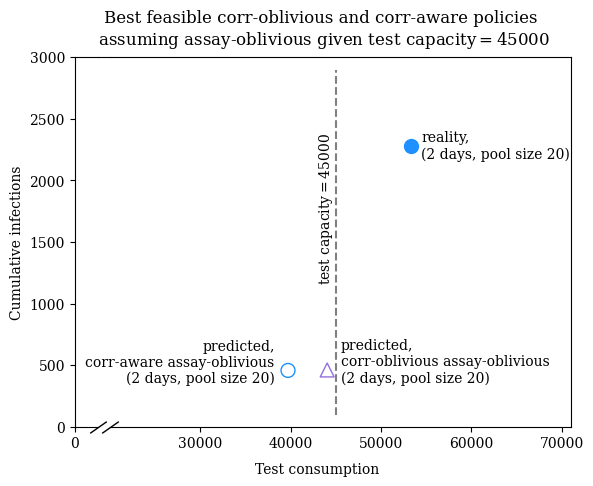

In [7]:
# use broken axis
# https://stackoverflow.com/questions/70700017/broken-y-axis-from-0-to-value-start-with-matplotlib-and-pandas-data

plt.rcParams["font.family"] = "serif"

plt.rcParams["font.family"] = "serif"
fig, axes = plt.subplots(
    1,
    2,
    sharex="col",
    sharey="row",
    gridspec_kw={
        #    'height_ratios': [1, 0.05],
        "width_ratios": [0.05, 1]
    },
)
ax1, ax2 = axes.flatten()
fig.subplots_adjust(hspace=0.05, wspace=0.05)

test_capacity = 45000

ax1.set_xlim(0, 100)
ax2.set_xlim(20000, 71000)
ax2.set_ylim(0, 3000)

# plot points for constant sensitivity

policy_idx_c = 0
while critical_test_consumptions_c[policy_idx_c] > test_capacity:
    policy_idx_c += 1

capacity_idx_c, true_optimal_policy_c, model_optimal_policy_c = policies_c[policy_idx_c]

modeled_outcome_c = df_c[
    (df_c["num_groups"] == model_optimal_policy_c[0])
    & (df_c["pool_size"] == model_optimal_policy_c[1])
]
optimal_outcome_c = df_c[
    (df_c["num_groups"] == true_optimal_policy_c[0])
    & (df_c["pool_size"] == true_optimal_policy_c[1])
]
actual_outcome_np_fixed = df[
    (df["num_groups"] == model_optimal_policy_c[0])
    & (df["pool_size"] == model_optimal_policy_c[1])
]
actual_outcome_cp_fixed = df[
    (df["num_groups"] == true_optimal_policy_c[0])
    & (df["pool_size"] == true_optimal_policy_c[1])
]


ax2.scatter(
    modeled_outcome_c["cum_num_tests_naive_mean"],
    modeled_outcome_c["cumInfections_naive_mean"],
    color="mediumpurple",
    marker="^",
    facecolors="none",
    label=f"predicted, Se=0.8,\ncorr-oblivious policy {model_optimal_policy_c}",
    s=100,
)
ax2.annotate(
    f"predicted,\ncorr-oblivious assay-oblivious\n({model_optimal_policy_c[0]} days, pool size {model_optimal_policy_c[1]})",
    (
        modeled_outcome_c["cum_num_tests_naive_mean"] + 1500,
        modeled_outcome_c["cumInfections_naive_mean"] - 100,
    ),
    ha="left",
)

ax2.scatter(
    optimal_outcome_c["cum_num_tests_correlated_weak_mean"],
    optimal_outcome_c["cumInfections_correlated_weak_mean"],
    color="dodgerblue",
    facecolors="none",
    marker="o",
    label=f"CP, predicted, fixed err, {true_optimal_policy_c}",
    s=100,
)
ax2.annotate(
    f"predicted,\ncorr-aware assay-oblivious\n({true_optimal_policy_c[0]} days, pool size {true_optimal_policy_c[1]})",
    (
        optimal_outcome_c["cum_num_tests_correlated_weak_mean"] - 1500,
        optimal_outcome_c["cumInfections_correlated_weak_mean"] - 100,
    ),
    ha="right",
)
ax2.scatter(
    actual_outcome_cp_fixed["cum_num_tests_correlated_weak_mean"],
    actual_outcome_cp_fixed["cumInfections_correlated_weak_mean"],
    color="dodgerblue",
    marker="o",
    label=f"CP, actual, fixed err, {true_optimal_policy_c}",
    s=100,
)
ax2.annotate(
    f"reality,\n({true_optimal_policy_c[0]} days, pool size {true_optimal_policy_c[1]})",
    (
        actual_outcome_cp_fixed["cum_num_tests_correlated_weak_mean"] + 1100,
        actual_outcome_cp_fixed["cumInfections_correlated_weak_mean"] - 100,
    ),
    ha="left",
)

plt.suptitle(
    f"Best feasible corr-oblivious and corr-aware policies\n assuming assay-oblivious given test capacity$=${test_capacity}",
    x=0.51,
    y=0.98,
)

ax2.vlines(
    x=test_capacity,
    ymin=100,
    ymax=2900,
    color="grey",
    linestyle="--",
)
ax2.annotate(
    f"test capacity$=${test_capacity}",
    (test_capacity - 100, 1200),
    ha="right",
    rotation=90,
)

ax2.set_xlabel("Test consumption")
ax1.set_ylabel("Cumulative infections")
ax2.xaxis.set_label_coords(0.45, -0.095)


ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.yaxis.set_ticks_position("none")
ax1.set_xticks(ax1.get_xticks()[:-1])
ax2.set_xticks(ax2.get_xticks()[1:-1])

d = 0.7  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,  # "length" of cut-line
    linestyle="none",
    color="k",
    mec="k",
    mew=1,  # line thickness
    clip_on=False,
)
ax1.plot([1], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [0], transform=ax2.transAxes, **kwargs)

horizontal_patch = plt.Line2D(
    (ax1.get_position().xmax, ax2.get_position().xmin),
    (ax1.get_position().ymax, ax1.get_position().ymax),
    color="k",
    linewidth=ax1.spines["top"]._linewidth,
)
fig.add_artist(horizontal_patch)
plt.savefig("../figures/Fig_7b.pdf", bbox_inches="tight")